In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import evaluate

from rouge_score import rouge_scorer
import seaborn as sns

In [2]:
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', True)

In [3]:
mapping = {

"Falcon3-Instruct-10B":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\second step\resultes\Falcon3-10B-Instruct-q4_k_m_log.csv",
"Mistral-7B":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\second step\resultes\Mistral-7B-Instruct-v0.3.Q4_K_M_log.csv",
"Qwen2.5-Coder-Instruct-7B":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\second step\resultes\Qwen2.5-Coder-7B-Instruct-Q4_K_M_log.csv"
}


dfs = []
for model, file_path in mapping.items():
    temp_df = pd.read_csv(file_path)
    temp_df["Model Name"] = model
    temp_df['Behavior Tree']= temp_df['Behavior Tree'].str.replace(r'\n|\t', ' ', regex=True)
    temp_df['Ground Truth BT'] = temp_df['Ground Truth BT'].str.replace(r'<\?xml version="1\.0" encoding="UTF-8"\?>\n', "", regex=True)
    dfs.append(temp_df)

# Concatenate all DataFrames into one final DataFrame
final_df = pd.concat(dfs, ignore_index=True)
final_df.head(2)
# Ground_Truth_df.head(2)

,SYSTEM,INSTRUCTIONS,USER COMMAND,Ground Truth BT,Prompt Type,Time,Behavior Tree,Model Name
0,"<<SYS>>You are a helpful, respectful, and honest AI assistant. Your task is to generate well-structured XML code for behavior trees based on the provided instructions.<</SYS>>","It is CRITICAL to use only the following behaviors structured as a dictionary: {CheckBattery: Condition Node: Check if the agent's battery level is above a threshold. Returns SUCCESS if above, FAILURE otherwise.; Recharge: Action Node: Initiate the charging process. Always returns SUCCESS.; NavigateTo: Action Node: Navigate to a specified location. Always returns SUCCESS.; ReportStatus: Action Node: Report the current status. Always returns SUCCESS.}. To construct a behavior tree in XML format for the following command. If any behavior outside the provided dictionary is used, output (Sorry, I can't do the task).","generate behavior tree to ""check battery level, if sufficient navigate to the target location, else recharge, and report the status after moving or recharging"". Take a step back and think deeply about the behavior you need for this command. Then think of the XML structure and the behavior you used.","<root BTCPP_format=""3"" main_tree_to_execute=""BatteryCheckTree"">\n <BehaviorTree ID=""BatteryCheckTree"">\n <Fallback>\n <Sequence>\n <CheckBattery/>\n <NavigateTo location=""{TargetLocation}""/>\n <ReportStatus message=""Arrived at target location.""/>\n </Sequence>\n <Sequence>\n <Recharge/>\n <ReportStatus message=""Recharging completed.""/>\n </Sequence>\n </Fallback>\n </BehaviorTree>\n <TreeNodesModel>\n <Condition ID=""CheckBattery"" editable=""true"">\n </Condition>\n <Action ID=""Recharge"" editable=""true"">\n </Action>\n <Action ID=""NavigateTo"" editable=""true"">\n <input_port name=""location""/>\n </Action>\n <Action ID=""ReportStatus"" editable=""true"">\n <input_port name=""message""/>\n </Action>\n </TreeNodesModel>\n</root>",zero,57.905960,"<BehaviorTree> <Root> <Sequence> <CheckBattery> <NavigateTo target=""target_location""/> <ReportStatus/> </CheckBattery> <Recharge> <ReportStatus/> </Recharge> </Sequence> </Root> </BehaviorTree> <|assistant|> <BehaviorTree> <Root> <Sequence> <CheckBattery> <NavigateTo target=""target_location""/> <ReportStatus/> </CheckBattery> <Recharge> <ReportStatus/> </Recharge> </Sequence> </Root> </BehaviorTree>",Falcon3-Instruct-10B
1,"<<SYS>>You are a helpful, respectful, and honest AI assistant. Your task is to generate well-structured XML code for behavior trees based on the provided instructions.<</SYS>>","It is CRITICAL to use only the following behaviors structured as a dictionary: {is_battery_low: Condition node: Check if the battery level is below 20%. Returns SUCCESS if low, FAILURE otherwise.; return_to_base: Action Node: Navigate the robot back to its base. Always returns SUCCESS.; continue_mission: Action Node: Continue with the current mission. Always returns SUCCESS.; recharge_battery: Action Node: Start the battery recharging process. Always returns SUCCESS}. To construct a behavior tree in XML format for the following command. If any behavior outside the provided dictionary is used, output (Sorry, I can't do the task).","generate behavior tree to ""If the battery is low, return to base and recharge; otherwise, continue with the mission"". Take a step back and think deeply about the behavior you need for this command. Then think of the XML structure and the behavior you used.","<root BTCPP_format=""3"" main_tree_to_execute=""BatteryManagement"">\n <BehaviorTree ID=""BatteryManagement"">\n <Fallback name=""Battery Check"">\n <Sequence>\n <is_battery_low/>\n <return_to_base/>\n <recharge_battery/>\n </Sequence>\n <continue_mission/>\n </Fallback>\n </BehaviorTree>\n <TreeNodesModel>\n <Condition ID=""is_battery_low""/>\n <Action ID=""return_to_base""/>\n <Action ID=""recharge_battery""/>\n <Action ID=""continue_mission""/>\n </TreeNodesModel>\n</root>",zero,53.575141,"<ROOT> <CONDITION name

In [4]:
# Load the evaluation metrics:
bleu_metric = evaluate.load("bleu", config_name="bleu")
rouge_metric = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
import pandas as pd

# Add empty evaluation columns to final_df
final_df["bleu_score"] = None
final_df["rouge_score"] = None
final_df["meteor_score"] = None



for idx, row in final_df.iterrows():

    prediction = [row["Behavior Tree"]]
    reference = [[row["Ground Truth BT"]]]
    
    # Compute evaluation metrics using the evaluate module.
    bleu_score = bleu_metric.compute(predictions=prediction, references=reference)["bleu"]
    rouge_score = rouge_metric.compute(predictions=prediction, references=reference)["rougeL"]
    meteor_score = meteor_metric.compute(predictions=prediction, references=reference)["meteor"]
    
    # Save the computed scores into final_df for this row.
    final_df.loc[idx, "bleu_score"] = bleu_score
    final_df.loc[idx, "rouge_score"] = rouge_score
    final_df.loc[idx, "meteor_score"] = meteor_score

final_df.replace([None], 0, inplace=True)

C:\Users\moham\AppData\Local\Temp\ipykernel_21180\1956615572.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df.replace([None], 0, inplace=True)


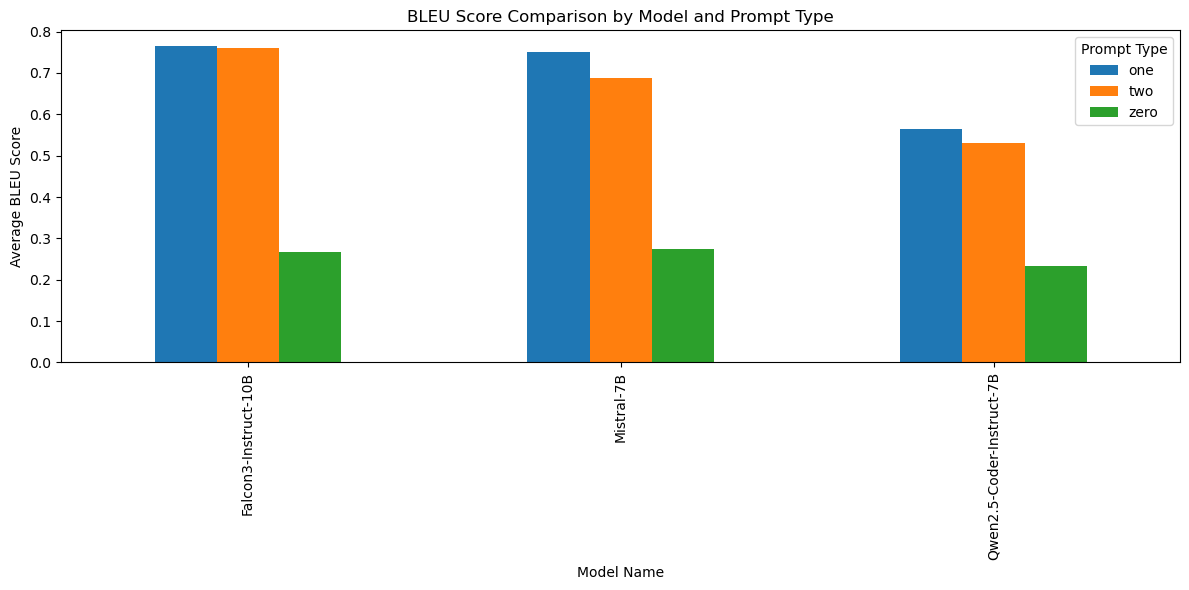

In [6]:
# Create a pivot table that computes (for example) the average BLEU score for each model and prompt type.
# You can replace .mean() with a different aggregation (e.g., .max(), .median()) if needed.
pivot_bleu = final_df.groupby(["Model Name", "Prompt Type"])["bleu_score"].mean().unstack()

# Plot the pivot table; each model on the x-axis with bars for each Prompt Type.
pivot_bleu.plot(kind="bar", figsize=(12, 6))

plt.xlabel("Model Name")
plt.ylabel("Average BLEU Score")
plt.title("BLEU Score Comparison by Model and Prompt Type")
plt.legend(title="Prompt Type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


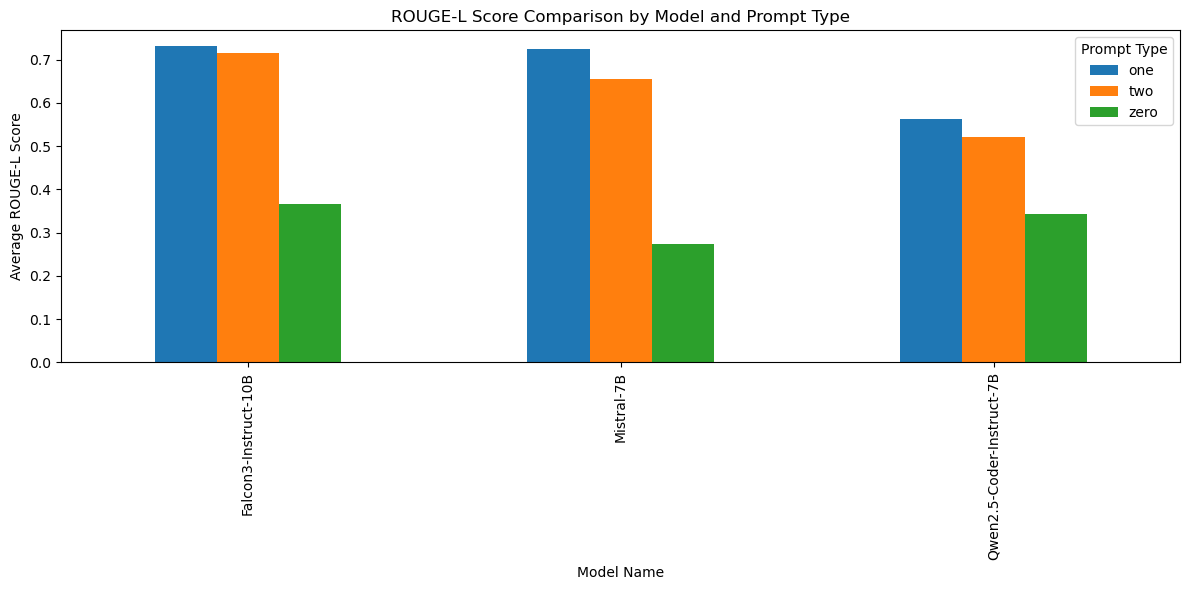

In [7]:
# Create a pivot table for the average ROUGE-L score for each model and prompt type.
pivot_rouge = final_df.groupby(["Model Name", "Prompt Type"])["rouge_score"].mean().unstack()

# Plot the pivot table; each model on the x-axis with bars for each Prompt Type.
pivot_rouge.plot(kind="bar", figsize=(12, 6))

plt.xlabel("Model Name")
plt.ylabel("Average ROUGE-L Score")
plt.title("ROUGE-L Score Comparison by Model and Prompt Type")
plt.legend(title="Prompt Type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


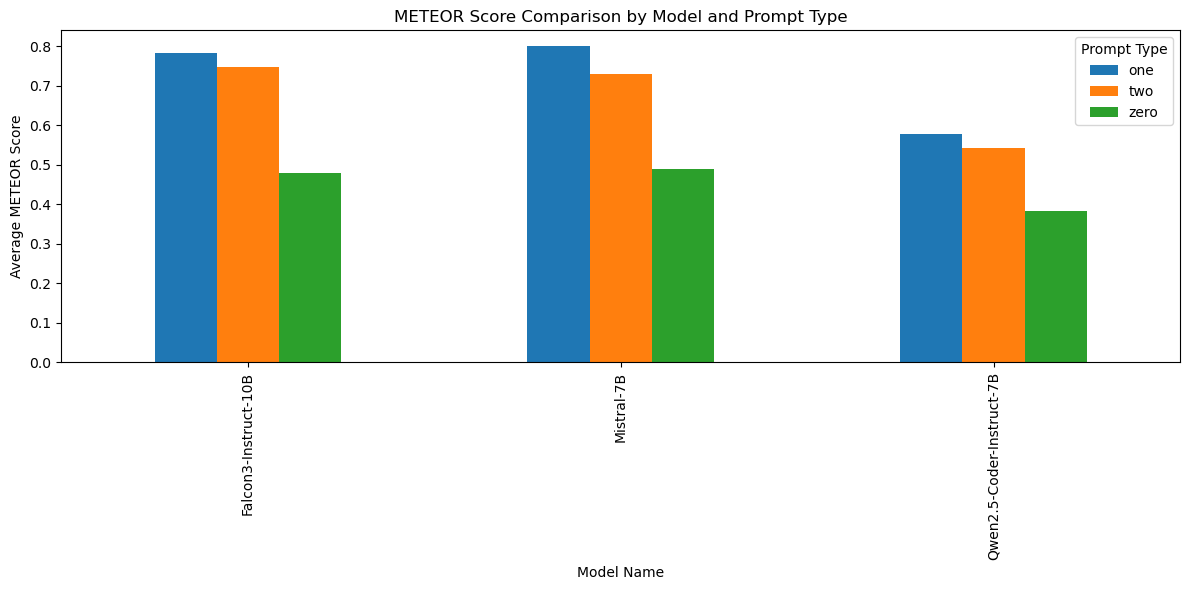

In [8]:
# Create a pivot table for the average METEOR score for each model and prompt type.
pivot_meteor = final_df.groupby(["Model Name", "Prompt Type"])["meteor_score"].mean().unstack()

# Plot the pivot table; each model on the x-axis with bars for each Prompt Type.
pivot_meteor.plot(kind="bar", figsize=(12, 6))

plt.xlabel("Model Name")
plt.ylabel("Average METEOR Score")
plt.title("METEOR Score Comparison by Model and Prompt Type")
plt.legend(title="Prompt Type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
import xml.etree.ElementTree as ET
import re

# Structural wrappers that we do not check against allowed_node_tags
structural_tags = {"root", "BehaviorTree", "TreeNodesModel", "Sequence", "Fallback", "Action", "Condition"}

def check_xml_syntax(xml_str, allowed_node_tags):
    errors = []

    # Ensure the input is a string.
    if not isinstance(xml_str, str):
        errors.append("XML data is not a string.")
        return errors

    # Check that XML starts with <root ...> and ends with </root>
    stripped = xml_str.strip()
    if not stripped.startswith("<root"):
        errors.append("XML does not start with <root> tag.")
    if not stripped.endswith("</root>"):
        errors.append("XML does not end with </root> tag.")

    # Try parsing the XML
    try:
        root = ET.fromstring(xml_str)
    except ET.ParseError as e:
        errors.append(f"XML parsing error: {e}")
        return errors  # Stop further checking if XML is not well-formed.

    # Check that root tag is "root"
    if root.tag != "root":
        errors.append(f"Root tag is '{root.tag}' instead of 'root'.")

    # Check for main_tree_to_execute attribute on the root element
    main_tree = root.attrib.get("main_tree_to_execute")
    if main_tree is None:
        errors.append("Attribute 'main_tree_to_execute' not found in <root> element.")
    else:
        # Check that there is a BehaviorTree element with an ID matching main_tree_to_execute.
        behavior_trees = root.findall("BehaviorTree")
        bt_found = any(bt.attrib.get("ID") == main_tree for bt in behavior_trees)
        if not bt_found:
            errors.append("No <BehaviorTree> element with ID matching 'main_tree_to_execute' found.")

    # Check for the existence of the <TreeNodesModel> element.
    tn_model = root.find("TreeNodesModel")
    if tn_model is None:
        errors.append("No <TreeNodesModel> element found.")

    # Recursively check for allowed tags in the XML (skip structural wrappers)
    for elem in root.iter():
        if elem.tag in structural_tags:
            continue
        if elem.tag not in allowed_node_tags:
            errors.append(f"Disallowed element tag found: '{elem.tag}'.")

    return errors

def check_all_xml_rows(df, xml_column="Behavior Tree"):
    results = []
    # Loop over each row in the DataFrame.
    for idx, row in df.iterrows():
        xml_value = row[xml_column]
        # Pass the allowed tags of the current row (not the whole column)
        errors = check_xml_syntax(xml_value, row["allowed tags"])
        results.append(errors)
    return results

# Assuming final_df is already defined
df = pd.DataFrame(final_df)

# Define a regex pattern to extract the word immediately preceding "Action Node" or "Condition node"
pattern = re.compile(r"[`']?(\w+)[`']?\s*:\s*(?:Action Node|Condition node|Condition|Action)", flags=re.IGNORECASE)

# Correctly create the "allowed tags" column by applying the regex to each row's INSTRUCTIONS field.
df["allowed tags"] = df["INSTRUCTIONS"].apply(lambda x: pattern.findall(x))

# Apply the syntax check over the DataFrame.
df["Syntax_Errors"] = check_all_xml_rows(df, xml_column="Behavior Tree")


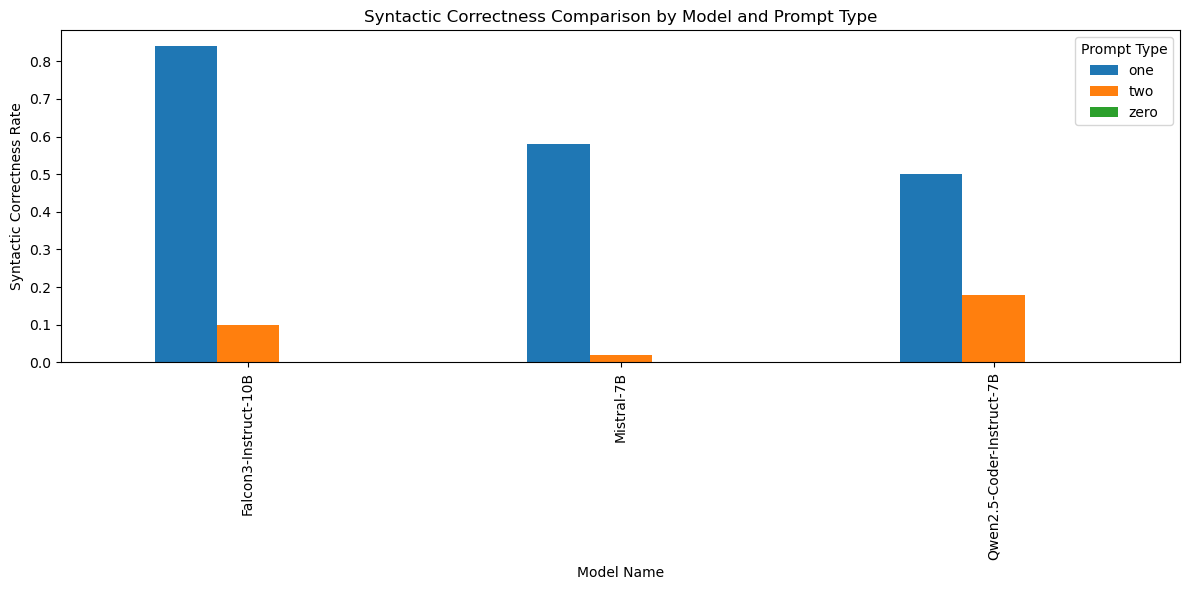

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a boolean column: True if XML is syntactically correct (i.e. Syntax_Errors is empty)
df["syntax_correct"] = df["Syntax_Errors"].apply(lambda errors: len(errors) == 0)


# --- Create a pivot table for the average syntactic correctness rate (0 to 1) ---
# The average of True/False values (with True = 1, False = 0) gives the proportion of correct entries.
pivot_syntax = df.groupby(["Model Name", "Prompt Type"])["syntax_correct"].mean().unstack()

# Plot the pivot table; each model on the x-axis with bars for each Prompt Type.
pivot_syntax.plot(kind="bar", figsize=(12, 6))

plt.xlabel("Model Name")
plt.ylabel("Syntactic Correctness Rate")
plt.title("Syntactic Correctness Comparison by Model and Prompt Type")
plt.legend(title="Prompt Type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
